In [2]:
import random
import torch
from torch import nn
from d2l import torch as d2l

class PairData(d2l.DataModule):
    def __init__(self, pairs, batch_size, num_steps=16, num_train=8196*16, num_val=256):
        super().__init__()
        self.save_hyperparameters()
        self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(pairs)

    def _build_arrays(self, pairs, src_vocab=None, tgt_vocab=None):
        def _build_array(sentences, vocab, is_tgt=False):
            pad_or_trim = lambda seq, t: (
                seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
            sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
            if is_tgt:
                sentences = [['<bos>'] + s for s in sentences]
            if vocab is None:
                vocab = d2l.Vocab(sentences, min_freq=2)
            array = d2l.tensor([vocab[s] for s in sentences])
            valid_len = d2l.reduce_sum(
                d2l.astype(array != vocab['<pad>'], d2l.int32), 1)
            return array, vocab, valid_len
        src, tgt = [], []
        for i, pair in enumerate(pairs):
            if i >= self.num_train + self.num_val:
                break
            src.append(pair[0])
            tgt.append(pair[1])
        src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
        tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
        return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]),
                src_vocab, tgt_vocab)

    def get_dataloader(self, train):
        idx = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader(self.arrays, train, idx)

    def build(self, src_sentences):
        pairs = zip(src_sentences, [[]] * len(src_sentences))
        arrays, _, _ = self._build_arrays(pairs, self.src_vocab, self.tgt_vocab)
        return arrays

def distributive_multiplication_data(max_factor_num=5):
    alphabet = list("abcdefghijklmnopqrstuvwxyz")
    while True:
        random.shuffle(alphabet)
        var_count = random.randint(2, max_factor_num + 1)
        vars = alphabet[:var_count]
        src_expr = [vars[0], '(', vars[1], *(e for v in vars[2:] for e in ('+', v)), ')']
        tgt_expr = [vars[0], vars[1], *(e for v in vars[2:] for e in ('+', vars[0], v))]
        # print(f'{src_expr} => {tgt_expr}')
        yield src_expr, tgt_expr

data = PairData(distributive_multiplication_data(), 256)
src, tgt_i, _, tgt_o = next(iter(data.val_dataloader()))
data.src_vocab.to_tokens(src[127]), data.tgt_vocab.to_tokens(tgt_o[127])
# data.src_vocab.to_tokens(data.arrays[0][-1:][0]), data.tgt_vocab.to_tokens(data.arrays[3][-1:][0])

(['w',
  '(',
  'h',
  '+',
  'e',
  '+',
  'n',
  ')',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>'],
 ['w',
  'h',
  '+',
  'w',
  'e',
  '+',
  'w',
  'n',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>'])

In [3]:
import math
import torch
from torch import nn
from d2l import torch as d2l
class AttentionDecoder(d2l.Decoder):
    def __init__(self):
        super().__init__()
    @property
    def attention_weights(self):
        raise NotImplementedError
class MultiHeadAttention(d2l.Module):
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        # dot prod attention is stateless
        self.attention = d2l.DotProductAttention(dropout)
        # multi-head attention is stateful with these params
        # num_hiddens = num_heads * hiddens_per_head
        # W_qkv actually is embed_size * num_hiddens
        # W_o actually is num_hiddens * num_hiddens
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)
    def transpose_qkv(self, X):
        X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
        X = X.permute(0, 2, 1, 3)
        return X.reshape(-1, X.shape[2], X.shape[3])
    def transpose_output(self, X):
        X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
        X = X.permute(0, 2, 1, 3)
        return X.reshape(X.shape[0], X.shape[1], -1)
    def forward(self, queries, keys, values, valid_lens):
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))
        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)
        output = self.attention(queries, keys, values, valid_lens)
        # output_concat has shape (batch_size, queries, num_hiddens)
        output_concat = self.transpose_output(output)
        # return shape (batch_size, queries, num_hiddens)
        return self.W_o(output_concat)
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32
                          ).reshape(-1, 1) / torch.pow(10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)
    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))
class AddNorm(nn.Module):
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)
class TransformerEncoderBlock(nn.Module):
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias=False):
        super().__init__()
        self.attention = MultiHeadAttention(num_hiddens, num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))
    def forward(self, X, valid_lens):
        # X shape: (batch_size, num_steps, embed_size)
        # since pos encoding values are between -1 and 1, to rescale the embedding values
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = []
        for blk in self.blks:
            X = blk(X, valid_lens)
            self.attention_weights.append(blk.attention.attention.attention_weights)
        return X
class TransformerDecoderBlock(nn.Module):
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        if state[2][self.i] is None:
            # case when training, forward just once for one batch
            # case when predict, forward every step, this is the first step
            key_values = X
        else:
            # case when predict, forward every step, this is the non-first step
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        batch_size, num_steps, _ = X.shape
        if self.training or num_steps > 1:  # when training or validating
            # only attention previous tokens
            dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:  # (num_steps == 1) when predicting
            dec_valid_lens = None
        # self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # encoder-decoder attention
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state
class TransformerDecoder(AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)
    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[], []]
        for blk in self.blks:
            X, state = blk(X, state)
            self._attention_weights[0].append(blk.attention1.attention.attention_weights)
            self._attention_weights[1].append(blk.attention2.attention.attention_weights)
        return self.dense(X), state
    @property
    def attention_weights(self):
        return self._attention_weights
class MySeq2Seq(d2l.Seq2Seq):
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder,tgt_pad, lr)
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        # self.y_hat = Y_hat
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)
    def accuracy(self, Y_hat, Y, averaged=True):
        preds = d2l.astype(d2l.argmax(Y_hat, dim=2), Y.dtype)
        compare = d2l.astype((preds == Y).all(dim=1), d2l.float32)
        return d2l.reduce_mean(compare) if averaged else compare


[Point(x=13.0, y=0.984375), Point(x=14.0, y=1.0), Point(x=15.0, y=1.0)]


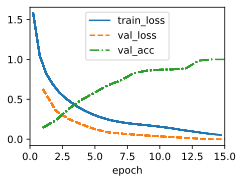

In [4]:
num_hiddens, num_blks, dropout = 32, 2, 0.2
ffn_num_hiddens, num_heads = 16, 4
encoder = TransformerEncoder(len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout)
decoder = TransformerDecoder(len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout)
model = MySeq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.001)
trainer = d2l.Trainer(max_epochs=15, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)
print(model.board.data['val_acc'][-3:])

In [5]:
print(model.board.data['val_acc'][-3:])
src = [data.src_vocab.to_tokens(s) for s in data.arrays[0][-1:]]
print(src)
preds, _ = model.predict_step(data.build(src), d2l.try_gpu(), data.num_steps)
print([data.tgt_vocab.to_tokens(p) for p in preds])
# x = [a[-1:] for a in list(data.val_dataloader())[0]]
# # x[1] = x[1][:, (0,1)]
# y = model(*x[:-1]) 
# data.tgt_vocab.to_tokens(y.argmax(dim=2)[0])

[Point(x=13.0, y=0.984375), Point(x=14.0, y=1.0), Point(x=15.0, y=1.0)]
[['w', '(', 'v', ')', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']]
[['w', 'v', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']]


In [6]:
preds, _ = model.predict_step(data.build([
    ['x', '(', 'y', '+', 'z', ')'], 
    ['a', '(', 'b', ')'],
    ['k', '(', 'o', '+', 'b', ')'],
    ]), d2l.try_gpu(), data.num_steps)
print([data.tgt_vocab.to_tokens(p) for p in preds])

[['x', 'y', '+', 'x', 'z', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['a', 'b', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['k', 'o', '+', 'k', 'b', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']]


tensor(3)